# Chapter 11
## Reinforcement learning

    Hand-in bug-free (try "Kernel" > "Restart & Run All") and including all (textual as well as figural) output via Blackboard before the deadline (see Blackboard).

Learning goals:
1. Reinforcement learning basics
1. Tabular Q-Learning
1. Neural network-based Q-learning

### Notes on the architecture

So far we have considered neural networks that learn in a supervised (provided with specific targets they should learn, e.g. classes) or unsupervised manner (not provided with targets, only data). 

Autonomous agents often learn from *rewards* (= positive or negative feedback quantities, i.e. this term includes rewards and punishments). In this set-up, the environment is considered a blackbox that returns a *reward* after an agent performs an *action*. In a typical setup rewards are the only thing agents know about their environment. This is the subject matter of reinforcement learning. 

In this assignment you will learn to implement an agent which can learn from its mistakes using reinforcement learning. 

We provide the environment `EvidenceEnv` that has a hidden world state (`0` or `1`). The task of the agent is to guess the right hidden world state, and the agent will receive a reward of `+1` or `-1` based on whether the guess was right or wrong respectively. The agent gets *evidence* from `EvidenceEnv` for being able to make an informed guess. The generated evidence is *equal* to the true state with probability $p$, and different from the true state with probability $1-p$. 

Please read the code and make sure to find as much of what we described inside it as possible. 

In [68]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import chainer
import chainer.links as L
import chainer.functions as F
from tqdm import tqdm_notebook

print chainer.__version__

4.1.0


In [69]:
class EvidenceEnv(object):
    """
    Very simple task which only requires evaluating present evidence and does not require evidence integration.
    The actor gets a reward when it correctly decides on the ground truth. Ground truth 0/1 influences 
    probabilistically the number of 0s or 1s in the evidence observations. 
    """

    def __init__(self, n=1, p=0.8):
        """
        Initializes the environment.
        
        Args:
            n = [int] number of pieces of evidence
            p = [flt] probability of emitting matching evidence
        """
        self.n_obs = n
        self.p = p
        self.n_action = 2
        self._state = None

    def reset(self):
        """
        Resets state and generates new observations. 

        Returns:
            observation = [int] new initial evidence
        """
        self._state = np.random.choice(2)  # generate new hidden state
        return self.observe()

    def step(self, action):
        """
        Takes and carries out the agent's action (the guess). Then proceeds to create a new state
        and new evidence. Returns evidence for new state and reward for guess on old state. 

        Args:
            action = [int] the action
        Returns:
            observation = [int] the observation
            reward      = [int] the reward
        """
        # reward is +1 for correct decision and -1 for incorrect decision: 
        reward = (2 * (action == self._state) - 1)  
        new_observations = self.reset()
        return new_observations, reward

    def observe(self):
        """
        Generate n_obs pieces of evidence for current state. 

        Returns:
            observation = [int] the observation
        """
        P = [self.p, 1 - self.p] if self._state == 0 else [1 - self.p, self.p]
        return np.random.choice(2, self.n_obs, True, P).astype('float32').reshape([1, self.n_obs])[0]

    # helper functions
    def asint(self, observations):
        """
        Represent list of 0,1 observations as an integer number.

        Args:
            observations = [list] binary array
        Returns:
            observations = [int] integer representation
        """
        return int(sum(2**i*b for i, b in enumerate(observations)))

    def asbinary(self, i, b_len):
        """
        Represent an integer as a 0,1 array.
        
        Args
            i     = [int] integer number
            b_len = [int] length of binary array
        Returns:
            b = [list] binary representation
        """
        b = [int(x) for x in list('{0:0b}'.format(i))]
        b = [0 for i in range(b_len - len(b))] + b
        return b

In [70]:
def run_agent(env, agent, epsilon=0, n_iter=1000):
    
    # Reset environment and agent, create first observation
    obs_old = env.reset()
    reward = None
    
    # Loop over iterations
    R = np.empty(n_iter)  # keep track of rewards
    for i_iter in range(n_iter):

        # Choose an action
        if i_iter > 0 and np.random.rand() < epsilon:  # epsilon determines whether we go for exploration or exploitation
            action = np.random.choice(env.n_action)  # random actions to explore environment (exploration)
        else:
            action = agent.act(obs_old) # strictly follow currently learned behaviour (exploitation)

        # Perform the selected action, get the reward, and a new observation for the next round
        obs_new, reward = env.step(action)

        # Adjust agent parameters (training step)
        agent.train(action, obs_old, reward, obs_new)

        # Update observation variable
        obs_old = obs_new

        # Track the rewards
        R[i_iter] = reward
        
    return R

In [71]:
# Create environment
env = EvidenceEnv(n=2, p=0.95)

### Exercise 1: Define random agent  (1P)
Define a random agent that just makes a random guess (random action, selected from uniform distribution). The function `.act` takes an observation, but you can ignore it here. 

Note that the initialized agent object will have a reference to the environment, being able to probe it from within the class. 

### Solution 1

In [72]:
class RandomAgent(object):
    """
    Implements a random agent.
    """

    def __init__(self, env):
        """
        Initializes an agent with an environment. 
        
        Args:
            env = [obj] the environment
        """
        self.env = env
        self.actions = self.env.n_action
        

    def act(self, observation):
        """
        Act based on observation. 
        
        Args:
            observation = [int] the observation
        Returns:
            action = [int] the action
        """
        ### Write code here. ###
        
        action = np.random.choice(self.env.n_action)
        
        
        return action

    def train(self, action, obs_old, reward, obs_new):
        """
        Trains the agent.
        
        Args:
            action  = [int] the action
            obs_old = [int] observation before action
            reward  = [int] reward after action
            obs_new = [int] observation after action
        """
        pass  # not implemented in this exercise, nothing to train

### Exercise 2: Run random agent (2P)

1. Initialize your random agent with the already initialized environment `env`.
1. Let the agent run with the environment with `run_agent`. Use a reasonable but small `epsilon`, e.g. `0.05`. 
1. Observe its behaviour by observing (plotting) the cumulative reward (cumulative sum of the reward) across 5000 iterations. 
1. Is it doing something rational?

### Solution 2

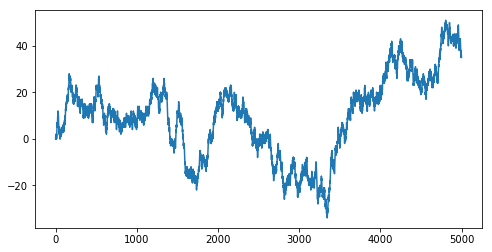

In [73]:
# Create agent
### Write code here ###
agent = RandomAgent(env)

# Put the agent in the environment
### Write code here ###
R = run_agent(env, agent, epsilon=0.05, n_iter=5000)

# Plot cumulative reward
### Write code here ###

fig, ax = plt.subplots(figsize = (8,4))

values = []
for r in range(len(R)):
    values.append(sum(R[:r]))
    
plt.plot(values)
plt.show()


### Exercise 3: Define tabular Q-learning (2 points)
We proceed to implement reinforcement learning via standard tabular Q-learning. The goal of Q-learning is to estimate the value of taking an action $a$ in an state $s$ (the observed state, not the hidden state). The agent selects that action which maximizes the value given an input state (observations). If you did not encounter reinforcement learning in the AI programme before, read the following blog up to and including the section Q-learning.
http://neuro.cs.ut.ee/demystifying-deep-reinforcement-learning/

Implement the tabular Q-learning algorithm by filling in the two missing lines of code below. Choosing the action means selecting $a = argmax_a Q(s, a)$. Updating the Q-table is merely applying the Q-learning update step together with the learning rate $\eta$ (`self.lr`), and discount factor $\gamma$ (`self.y`); then saving the resulting new value $Q(s,a)$ in the lookup table. 

Using the Bellman equation: 

$Q(s, a) = Q(s, a) + \eta (r + \gamma Q(s', a') - Q(s, a))$

### Solution 3

In [74]:
class TabularQAgent(object):
    """
    Implements Tabular Q agent.

    """

    def __init__(self, env):
        """
        Initializes an agent.
        
        Args:
            env = [obj] the environment
        """

        self.env = env

        n_obs = env.asint(np.array([1 for i in range(env.n_obs)]))+1

        # Initialize the Q-table (s,a) with all zeros
        self.Q = np.zeros([n_obs, env.n_action])

        # Set learning parameters
        self.lr = 1.0
        self.y = 0.95  # gamma

    def act(self, observation):
        """
        Act based on observation.
        
        Args:
            observation = [int] the observation
        Returns:
            action = [int] the action
        """

        # Transform observation to integer representation
        s = self.env.asint(observation)

        # Choose an action by greedily picking from the Q-table (corresponding entry for s and a)
        ### Write code here ###
        
        a = np.argmax(self.Q[s,:])

        return a

    def train(self, a, old_obs, r, new_obs):
        """
        Trains the agent.
        
        Args:
            action  = [int] the action
            obs_old = [int] observation before action
            reward  = [int] reward after action
            obs_new = [int] observation after action
        """

        s = self.env.asint(old_obs)
        s1 = self.env.asint(new_obs)

        # Update the Q-table
        ### Write code here ###
        
        #  Q(s,a)=Q(s,a)+η(r+γQ(s′,a′)−Q(s,a))
        
        old = self.Q[s,a]
        new = self.Q[s1,:]
        
        self.Q[s,a] = self.Q[s,a] + self.lr*(r + self.y*(np.argmax(new)) - self.Q[s,a])
        
        return self.Q[s,a]
        
    def get_Q(self):
        """
        Returns the Q table.
        
        Returns:
            Q = [n_obs, n_actions] the Q table
        """
        return self.Q

### Exercise 4: Run Tabular Q-agent (2 points)
1. Just like for the random agent, initialize a tabular Q-agent with the environment `env`.
1. Run it for 5000 iterations.
1. Observe its behaviour by plotting the cumulative reward. 
1. Also plot the cumulative reward of the random agent for comparison into the same figure. Is the Q-agent doing better?
1. Also plot $Q(s,a)$ (the Q-table) before and after learning via `plt.imshow()`. Call `agent.get_Q()` to get the Q-table. 

### Solution 4

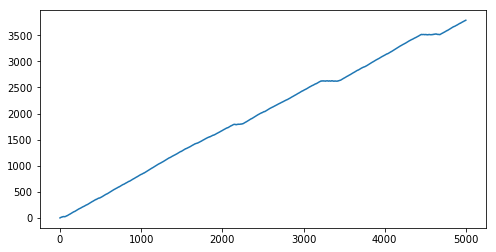

[[ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]]
[[ 1.95 -1.  ]
 [-1.   -1.  ]
 [-1.   -1.  ]
 [-0.05  1.  ]]


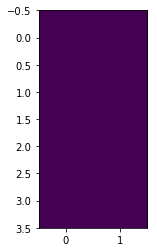

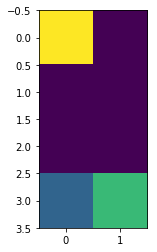

In [75]:
# Create agent
### Write code here ###
t_agent = TabularQAgent(env)
# Save initial Q table
### Write code here ###
init_q = np.copy(t_agent.get_Q())

# Run agent
### Write code here ###
R = run_agent(env, t_agent, epsilon=0.05, n_iter=5000)

# Plot cumulative reward
### Write code here ###
fig, ax = plt.subplots(figsize = (8,4))

values = []
for r in range(len(R)):
    values.append(sum(R[:r]))
    
plt.plot(values)
plt.show()

# Plot Q table before and after training
### Write code here ###
fin_q = t_agent.get_Q()

print init_q
print fin_q

plt.figure()
plt.imshow(init_q, cmap='viridis')
plt.figure()
plt.imshow(fin_q, cmap='viridis')

### Exercise 5: Neural Network-based Q-learning (2 points)

1. Ideally we want to get rid of the tabular representation. Read the rest of the blog post. Why is this lookup table impractical?

We will implement an agent which uses an MLP that takes observations and learns to output the Q value for all possible actions. This is done by backpropagation on the loss defined by the sum squared difference between the predicted and desired Q values. For simplicity we backpropagate per example.

1. Implement an MLP in chainer with two linear weight layers. It should use a ReLU activation function at the first layer and a linear (identity) activation at the second layer, producing the output `y`.
1. Fill in the missing lines in the `act()` and `train()` functions. It is quite similar to the Tabular Q learning algorithm, although you use the predicted q-values. For a more in depth explanation, read the last sections in http://neuro.cs.ut.ee/demystifying-deep-reinforcement-learning/

### Solution 5

In [76]:
class MLP(chainer.Chain):

    def __init__(self, n_hidden, n_out):
        super(MLP, self).__init__()
        with self.init_scope():
        ### Write code here ###
            self.l1 = L.Linear(None, n_hidden)
            self.l2 = L.Linear(n_hidden, n_out)

    def __call__(self, x):
        ### Write code here ###
        h = F.relu(self.l1(x))
        y = self.l2(h)
        return y

In [77]:
class NeuralQAgent(object):
    """
    Implements a Neural Q agent.
    """

    def __init__(self, env):
        """
        Initializes an agent.
        
        Args:
            env = [obj] the environment
        """
        self.env = env
        self.n_obs = env.asint(np.array([1 for i in range(env.n_obs)]))+1
        

        self.model = MLP(2,self.env.n_action)

        # Setup an optimizer
        self.opt = chainer.optimizers.Adam()
        self.opt.setup(self.model)
        
        # Set learning parameters
        self.lr = 1.0
        self.y = 0.95

    def act(self, observation):
        """
        Act based on observation.
        
        Args:
            observation = [int] the observation
        Returns:
            action = [int] the action
        """
        

        # transform observation to integer representation
        int_obs = np.atleast_2d(observation)
        
        # apply q-learning neural network to get q-value estimation
        ### Write code here ###
        
        q_estimate = self.model(int_obs)

        # choose an action by greedily picking from Q table
        ### Write code here ###
        a = F.argmax(q_estimate)

        # keep track of selected q value in self._qvalue (needed for training)
        ### Write code here ###
        self._qvalue = F.max(q_estimate)

        return a.data

    def train(self, a, old_obs, r, new_obs):
        """
        Trains the agent.
        
        Args:
            action  = [int] the action
            obs_old = [int] observation before action
            reward  = [int] reward after action
            obs_new = [int] observation after action
        """
        qvalue = self._qvalue
        s1 = np.atleast_2d(new_obs)

        # compute the 'right' (target) q-value qtarget for this state (via the same equation you used earlier)
        ### Write code here ###
#         self.Q[s,a] = self.Q[s,a] + self.lr*(r + self.y*(F.argmax(new)) - self.Q[s,a])

#         Q(s,a)=r + γ*max_a′(Q(s′,a′))
        qtarget = r + self.y * F.max(self.model(s1))

        # compute loss, compute gradients (backpropagate) and update the weights: 
        self.model.cleargrads()
        loss = F.mean_squared_error(qvalue, qtarget)
        loss.backward()
        self.opt.update()
        
    def get_Q(self):
        """
        Returns the Q table.
        
        Returns:
            Q = [n_obs, n_actions] the Q table
        """
        Q = np.zeros([self.n_obs, self.env.n_action])
        for i in range(self.n_obs):
            obs = np.array(self.env.asbinary(i, self.env.n_obs)).astype('float32')
            qvalues = self.model(np.atleast_2d(obs))
            Q[i] = qvalues.data
        return Q
    
    def reset_state(self):
        pass

### Exercise 6: Run the NeuralQAgent (1P)

1. Initialize `NeuralQAgent` with the environment and let it run for 5000 epochs.
1. Observe its behaviour by plotting the cumulative reward. Plot the reward of the random and the tabular Q-agents for comparison.
1. Also plot the learned Q-values before and afterer learning again. You get them by calling `agent.get_Q()`. 

### Solution 6

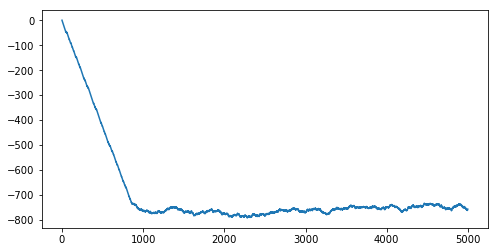

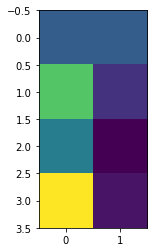

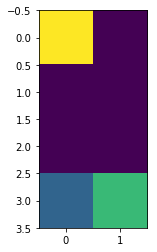

In [80]:
# Create agent
### Write code here ###
neural_agent = NeuralQAgent(env)
# Save initial Q table
### Write code here ###
init_q = np.copy(neural_agent.get_Q())

# Run agent
### Write code here ###
R = run_agent(env, neural_agent, epsilon=0.05, n_iter=5000)

# Plot cumulative reward
### Write code here ###

fig, ax = plt.subplots(figsize = (8,4))

values = []
for r in range(len(R)):
    values.append(sum(R[:r]))
    
plt.plot(values)
plt.show()

# Plot Q table before and after training
### Write code here ###

fin_q = t_agent.get_Q()

# print init_q
# print fin_q

plt.figure()
plt.imshow(init_q, cmap='viridis')
plt.figure()
plt.imshow(fin_q, cmap='viridis')

This was only a first step in reinforcement learing, and Q-learning with neural networks. Note further that we did not implement the various training tricks that were mentioned in the lecture. Also, we are dealing with an environment in which the reward does not depend on the past. More general setups require that we deal with past influences as well. 

If you want to go further:  The framework we defined here adheres to OpenAI `gym`’s definitions: https://gym.openai.com You can use your implementation as a basis for solving state-of-the-art reinforcement learning tasks, such as gait learning or Atari games. Other interesting places to go further: 

* **PsychLab**: Solving classical psychology experiments with current AI to research artificial and biological intelligence and their differences: https://deepmind.com/blog/open-sourcing-psychlab/
* **OpenAI Retro Contest**: Current transfer learning contest: https://contest.openai.com